In [1]:

import tensorflow as tf
import numpy as np
import h5py
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Configure Keras to use GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

2024-09-01 14:07:52.475339: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-01 14:07:52.509624: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-01 14:07:52.509654: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-01 14:07:52.509679: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-01 14:07:52.516249: I tensorflow/core/platform/cpu_feature_g

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks

class DataLoader:
    def __init__(self, h5_filename):
        self.h5_filename = h5_filename
        self.images, self.centers = self.load_data()

    def load_data(self):
        with h5py.File(self.h5_filename, 'r') as f:
            images = np.array(f['images'])
            centers = np.array(f['centers_training'])
        return images, centers

    def plot_image_with_centers(self, image_index=None):
        if image_index is None:
            image_index = np.random.randint(0, len(self.images))

        image = self.images[image_index]
        centers = self.centers[image_index]

        plt.imshow(image, cmap='gray')
        valid_centers = centers[centers[:, 0] == 1]
        for center in valid_centers:
            plt.scatter(center[1], center[2], c='red', marker='x')  # center[1] is x and center[2] is y
        plt.title('Image with Valid Centers Marked')
        plt.colorbar()
        plt.show()

    @staticmethod
    def sort_centers(centers):
        return centers[np.lexsort((centers[:, 0], centers[:, 1]))]

    def normalize_data(self):
        normalized_images = self.images / np.max(self.images)
        sorted_centers = np.array([self.sort_centers(image_centers[:, 1:]) for image_centers in self.centers])
        normalized_centers = sorted_centers / 64
        normalized_midpoints = tf.expand_dims(normalized_centers, axis=1)
        return normalized_images, normalized_midpoints.numpy()

    def split_data(self, train_size=0.82, random_state=42):
        normalized_images, normalized_midpoints_np = self.normalize_data()
        return train_test_split(normalized_images, normalized_midpoints_np, train_size=train_size, random_state=random_state)


class ModelBuilder:
    def __init__(self, input_shape=(64, 64, 1), num_classes=3, num_coordinates=2, learning_rate=1e-3):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_coordinates = num_coordinates
        self.learning_rate = learning_rate
        self.model = self.build_model()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

    def build_model(self):
        x_input = layers.Input(shape=self.input_shape)
        x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
        x = layers.MaxPool2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
        
        x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        
        x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.4)(x)
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.4)(x)
        
        x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.4)(x)
        
        x = layers.Flatten()(x)
        
        x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='sigmoid', name='x_midpoints')(x)
        x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
        return tf.keras.models.Model(x_input, x_midpoints_reshape)

    def compile_model(self, loss_function):
        self.model.compile(optimizer=self.optimizer, loss=loss_function)

    def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
        history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
        return history


@tf.keras.utils.register_keras_serializable()
class DynamicExponentCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_exponent=3, increment=1, update_frequency=10):
        super().__init__()
        self.exponent = initial_exponent
        self.increment = increment
        self.update_frequency = update_frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.update_frequency == 0:
            self.exponent += self.increment
            print(f"\nEpoch {epoch + 1}: Increasing exponent to {self.exponent}")
            self.model.loss = self.custom_loss(self.exponent)

    def custom_loss(self, exponent):
        def loss(y_true, y_pred):
            diff = tf.abs(y_true - y_pred)
            powered_diff = tf.pow(diff, exponent)
            return tf.reduce_mean(powered_diff)
        return loss

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'initial_exponent': self.exponent,
            'increment': self.increment,
            'update_frequency': self.update_frequency,
        })
        return config


class CustomModelCheckpoint(callbacks.Callback):
    def __init__(self, save_freq, save_path):
        super(CustomModelCheckpoint, self).__init__()
        self.save_freq = save_freq
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            self.model.save(self.save_path.format(epoch=epoch + 1))
            print(f"Model saved at epoch {epoch + 1}")



In [3]:
# Initialize the DataLoader with the path to the HDF5 file
h5_filename = '/home/m3-learning/Documents/Research Data/Electron Detection/Data Generated/Padded_120KMixedImages.h5'

# h5_filename = '/home/m3-learning/Documents/Research Data/Electron Detection/Data Generated/100KMixedImages.h5'


data_loader = DataLoader(h5_filename)

# Load images and centers
images, centers = data_loader.load_data()


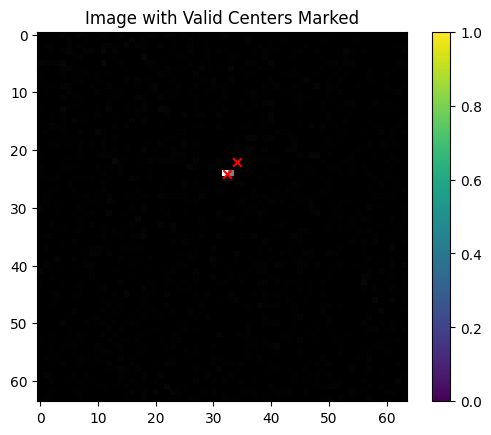

In [4]:

# Optional: Plot a random image with valid centers marked
data_loader.plot_image_with_centers()


In [5]:
# Normalize the data and split it into training and validation sets
train_images, val_images, train_midpoints, val_midpoints = data_loader.split_data()

# Check the shape of the datasets
print(f'Train Images: {train_images.shape}, Train Midpoints: {train_midpoints.shape}')
print(f'Validation Images: {val_images.shape}, Validation Midpoints: {val_midpoints.shape}')


2024-09-01 14:08:40.591056: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21416 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


Train Images: (98400, 64, 64), Train Midpoints: (98400, 1, 3, 2)
Validation Images: (21600, 64, 64), Validation Midpoints: (21600, 1, 3, 2)


In [6]:
# Convert the data to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))

# Batch and shuffle the datasets
batch_size = 800
train_dataset = train_dataset.shuffle(buffer_size=2000, reshuffle_each_iteration=True).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=2000).batch(batch_size)


In [7]:
# Initialize the ModelBuilder
model_builder = ModelBuilder()

# Build the model
model = model_builder.build_model()

# Display the model architecture
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_7 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 128)       7385

In [8]:
# # Initialize the dynamic exponent callback
# dynamic_exponent_callback = DynamicExponentCallback(initial_exponent=2, increment=1, update_frequency=7)

# # Compile the model with the custom loss function
# model_builder.compile_model(loss_function=dynamic_exponent_callback.custom_loss(2))


In [8]:
# Define the save path for the model checkpoints
save_path = "/home/da886/ElectronCountingProject/weights for custom loss/customlossmodel_epoch_{epoch:02d}.h5"
checkpoint_callback = CustomModelCheckpoint(save_freq=200, save_path=save_path)

# Define the learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=7, verbose=1, mode='min', min_lr=7e-15
)


In [9]:
model_builder.compile_model(loss_function=tf.keras.losses.MeanSquaredError())

In [10]:
# Train the model
history = model_builder.train_model(
    train_dataset, val_dataset, epochs=310, callbacks_list=[lr_scheduler]
)


Epoch 1/310


2024-09-01 14:09:03.000819: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-09-01 14:09:03.368240: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-09-01 14:09:08.307317: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x735837ab4a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-01 14:09:08.307341: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-09-01 14:09:08.311270: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-01 14:09:08.425439: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled 

246/246 [==============================] - 107s 366ms/step - loss: 0.0304 - val_loss: 0.1512 - lr: 0.0010
Epoch 2/310
246/246 [==============================] - 91s 370ms/step - loss: 0.0149 - val_loss: 0.0135 - lr: 0.0010
Epoch 3/310
246/246 [==============================] - 90s 367ms/step - loss: 0.0133 - val_loss: 0.0139 - lr: 0.0010
Epoch 4/310
246/246 [==============================] - 90s 366ms/step - loss: 0.0129 - val_loss: 0.0121 - lr: 0.0010
Epoch 5/310
246/246 [==============================] - 77s 314ms/step - loss: 0.0126 - val_loss: 0.0119 - lr: 0.0010
Epoch 6/310
246/246 [==============================] - 76s 310ms/step - loss: 0.0125 - val_loss: 0.0131 - lr: 0.0010
Epoch 7/310
246/246 [==============================] - 76s 309ms/step - loss: 0.0123 - val_loss: 0.0123 - lr: 0.0010
Epoch 8/310
246/246 [==============================] - 76s 309ms/step - loss: 0.0122 - val_loss: 0.0135 - lr: 0.0010
Epoch 9/310
246/246 [==============================] - 82s 332ms/step - los

KeyboardInterrupt: 

In [11]:



# Extract the losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']


train_loss_x_midpoints = history.history.get('x_midpoints_reshape_loss', train_loss)
val_loss_x_midpoints = history.history.get('val_x_midpoints_reshape_loss', val_loss)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.plot(train_loss_x_midpoints, label='Train Loss x_midpoints_reshape')
plt.plot(val_loss_x_midpoints, label='Validation Loss x_midpoints_reshape')
plt.xlabel('Epochs')
plt.yscale('log')

plt.ylabel('Loss')
plt.title('Training and Validation Loss ')
plt.legend()

plt.tight_layout()
plt.show()


NameError: name 'history' is not defined

In [104]:
# loadedmodel = tf.keras.models.load_model('/home/m3-learning/Documents/Research Data/Electron Detection/Weights/Weights for overfitting/Classescopy_0830model100Kimages.h5')

In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
train_dataset = train_dataset.batch(800)
inputs,targets = next(iter(train_dataset))
output =model_builder.model.predict(inputs)

# val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))
# val_dataset = val_dataset.batch(800)
# inputs,targets = next(iter(val_dataset))
# output =model_builder.model.predict(inputs)

25/25 [==============================] - 0s 8ms/step


In [58]:
# import numpy as np
# import matplotlib.pyplot as plt

# def visualize_midpoints(image, midpoints):
#     """
#     Visualizes midpoints on an image without using a probability vector.

#     Parameters:
#     - image: A 3D tensor representing the image.
#     - midpoints: A 2D tensor representing the midpoint coordinates (x, y).

#     Returns:
#     None (displays the image with midpoints).
#     """
#     # Convert to NumPy arrays for easier handling
#     image_np = image
#     midpoints_np = midpoints

#     # Denormalize image if necessary (adjust based on your normalization method)
#     denormalized_image = image_np  # Modify if normalization was applied during training

#     # Visualize the image
#     plt.figure(figsize=(4, 4))
#     plt.imshow(denormalized_image, cmap='gray')
#     plt.title("Predicted Midpoint Visualization")

#     # Plot midpoints directly
#     for i, (x, y) in enumerate(midpoints_np):
#         plt.scatter(x, y, color='red', s=5)

#     plt.show()

# def visualize_midpoints2(image, midpoints):
#     """
#     Visualizes ground truth midpoints on an image without using a probability vector.

#     Parameters:
#     - image: A 3D tensor representing the image.
#     - midpoints: A 2D tensor representing the midpoint coordinates (x, y).

#     Returns:
#     None (displays the image with midpoints).
#     """
    
#     image_np = image
#     midpoints_np = midpoints 
#     denormalized_image = image_np 

#     # Visualize the image
#     plt.figure(figsize=(4, 4))
#     plt.imshow(denormalized_image, cmap='gray')
#     plt.title("Ground Truth Midpoint Visualization")

#     # Plot midpoints directly
#     for i, (x, y) in enumerate(midpoints_np):
#         plt.scatter(x, y, color='red', s=5)

#     plt.show()

# # Example usage with random data
# t = np.random.randint(0, 800)
# # t=100

# visualize_midpoints(tf.convert_to_tensor(inputs[t]), tf.convert_to_tensor(output[t,0,:,:])*64)
# visualize_midpoints2(tf.convert_to_tensor(inputs[t]), tf.convert_to_tensor(targets[t,0,:,:])*64)


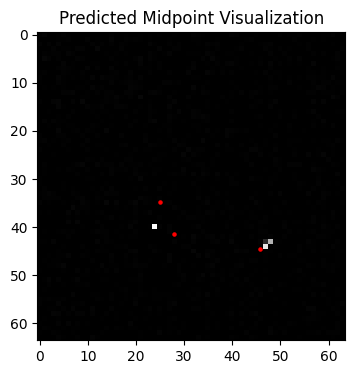

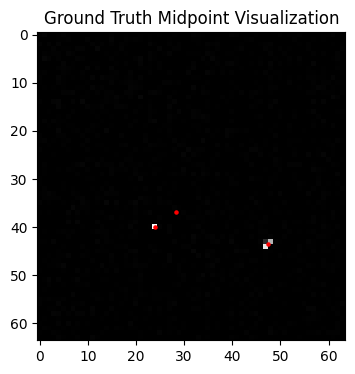

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_midpoints(image, midpoints):
    """
    Visualizes midpoints on an image without using a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    midpoints_np = midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Predicted Midpoint Visualization")

    # Plot midpoints directly, only if they are not (0, 0)
    for i, (x, y) in enumerate(midpoints_np):
        if x >= 3 and y >= 3:  # Only plot if the point is not (0, 0)
            plt.scatter(x, y, color='red', s=5)

    plt.show()

def visualize_midpoints2(image, midpoints):
    """
    Visualizes ground truth midpoints on an image without using a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).

    Returns:
    None (displays the image with midpoints).
    """
    image_np = image
    midpoints_np = midpoints
    denormalized_image = image_np 

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Ground Truth Midpoint Visualization")

    # Plot midpoints directly, only if they are not (0, 0)
    for i, (x, y) in enumerate(midpoints_np):
        # if x != 0 and y != 0:  # Only plot if the point is not (0, 0)
        if x >= 3 and y >= 3:
            plt.scatter(x, y, color='red', s=5)

    plt.show()

# Example usage with random data
t = np.random.randint(0, 800)
# t=100

visualize_midpoints(tf.convert_to_tensor(inputs[t]), tf.convert_to_tensor(output[t,0,:,:])*64)
visualize_midpoints2(tf.convert_to_tensor(inputs[t]), tf.convert_to_tensor(targets[t,0,:,:])*64)


In [39]:
model_builder.model.save('/home/m3-learning/Documents/Research Data/Electron Detection/Weights/Weights for overfitting/Classescopy_0901modelPadded100Kimages.keras')

In [27]:
train_loss = loadedmodel.evaluate(train_images, train_midpoints, verbose=0)

In [28]:
train_loss

0.002658843295648694

In [67]:
val_loss = loadedmodel.evaluate(val_dataset)
val_loss

25/25 [==============================] - 5s 190ms/step - loss: 0.0033


0.003311577718704939

In [107]:
# Calculate the MSE for each sample in the batch
mse_values = np.mean(np.square(output - targets),axis=2, dtype=np.float64)

# Find the minimum and maximum MSE
min_mse = np.min(mse_values)
max_mse = np.max(mse_values)

# Print the results
print(f"Minimum MSE in the batch: {min_mse}")
print(f"Maximum MSE in the batch: {max_mse}")

Minimum MSE in the batch: 5.5803812237797956e-08
Maximum MSE in the batch: 0.10307586666272073


In [108]:
mse_values.shape

(800, 1, 2)

In [109]:
# Find the indices of the minimum and maximum MSE
min_mse_index = np.argmin(mse_values)
max_mse_index = np.argmax(mse_values)

# Retrieve the predictions and ground truths for these indices
min_mse_prediction = output[min_mse_index]
min_mse_ground_truth = targets[min_mse_index]

max_mse_prediction = output[max_mse_index]
max_mse_ground_truth = targets[max_mse_index]

In [110]:
max_mse_prediction,max_mse_ground_truth

(array([[[0.7838853 , 0.2415526 ],
         [0.41625533, 0.308994  ],
         [0.7223252 , 0.469225  ]]], dtype=float32),
 <tf.Tensor: shape=(1, 3, 2), dtype=float32, numpy=
 array([[[0.765625  , 0.25072262],
         [0.4375    , 0.310148  ],
         [0.7202122 , 0.46875   ]]], dtype=float32)>)

In [111]:
# Print the shapes of the ground truth and predictions
print(f"Shape of min_mse_ground_truth: {min_mse_ground_truth.shape}")
print(f"Shape of min_mse_prediction: {min_mse_prediction.shape}")
print(f"Shape of max_mse_ground_truth: {max_mse_ground_truth.shape}")
print(f"Shape of max_mse_prediction: {max_mse_prediction.shape}")


Shape of min_mse_ground_truth: (1, 3, 2)
Shape of min_mse_prediction: (1, 3, 2)
Shape of max_mse_ground_truth: (1, 3, 2)
Shape of max_mse_prediction: (1, 3, 2)


In [112]:
import matplotlib.pyplot as plt

# Retrieve the images corresponding to the minimum and maximum MSE
min_mse_image = inputs[min_mse_index]
max_mse_image = inputs[max_mse_index]


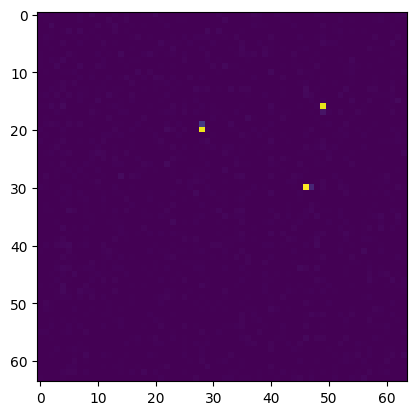

In [113]:
plt.imshow(max_mse_image)

In [52]:
max_mse_index

2

In [51]:
min_mse_index

5

In [74]:
min_mse_image

<tf.Tensor: shape=(64, 64), dtype=float64, numpy=
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00784314],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00784314, 0.00784314, ..., 0.00392157, 0.00392157,
        0.00392157],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.00392157,
        0.        ],
       [0.        , 0.        , 0.00392157, ..., 0.00784314, 0.        ,
        0.00392157],
       [0.        , 0.00392157, 0.00392157, ..., 0.        , 0.        ,
        0.00392157]])>

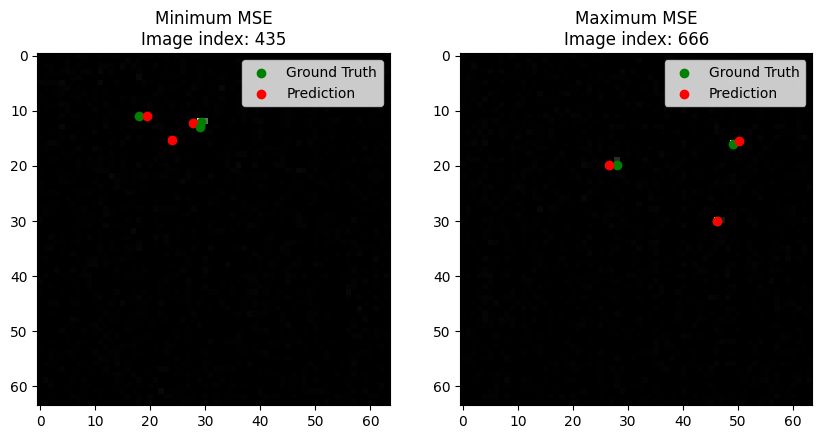

In [114]:
import matplotlib.pyplot as plt

# Remove the batch dimension (first dimension) since it's 1
min_mse_ground_truth_points = min_mse_ground_truth[0]
min_mse_prediction_points = min_mse_prediction[0]
max_mse_ground_truth_points = max_mse_ground_truth[0]
max_mse_prediction_points = max_mse_prediction[0]

plt.figure(figsize=(10, 5))

# Plot the image with the minimum MSE
plt.subplot(1, 2, 1)
plt.imshow(min_mse_image, cmap='gray')  # Assuming images are grayscale; remove cmap if RGB

# Plot each of the 3 points
for i in range(3):
    plt.scatter(min_mse_ground_truth_points[i, 0]*64, min_mse_ground_truth_points[i, 1]*64, color='green', label='Ground Truth' if i == 0 else "")
    plt.scatter(min_mse_prediction_points[i, 0]*64, min_mse_prediction_points[i, 1]*64, color='red', label='Prediction' if i == 0 else "")

plt.title(f'Minimum MSE\nImage index: {min_mse_index}')
plt.legend()

# Plot the image with the maximum MSE
plt.subplot(1, 2, 2)
plt.imshow(max_mse_image, cmap='gray')  # Assuming images are grayscale; remove cmap if RGB

# Plot each of the 3 points
for i in range(3):
    plt.scatter(max_mse_ground_truth_points[i, 0]*64, max_mse_ground_truth_points[i, 1]*64, color='green', label='Ground Truth' if i == 0 else "")
    plt.scatter(max_mse_prediction_points[i, 0]*64, max_mse_prediction_points[i, 1]*64, color='red', label='Prediction' if i == 0 else "")

plt.title(f'Maximum MSE\nImage index: {max_mse_index}')
plt.legend()

plt.show()
